# Toxic Comment Classification 

[Kaggle - Toxic Comment Classification Challenage](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview)

> Build a multi-headed model to detect different types of of toxicity like threats, obscenity, insults, and identity-based. 

## Notes on Related Resources

* [How AI Is Learning to Identify Toxic Online Content](https://www.scientificamerican.com/article/can-ai-identify-toxic-online-content/)
>  This is how our team built Detoxify, an open-source, user-friendly comment detection library to identify inappropriate or harmful text online. Its intended use is to help researchers and practitioners identify potential toxic comments. ... Each model can be easily accessed in one line of code and all models and training code are [publicly available on GitHub (Detoxify)]((https://github.com/unitaryai/detoxify)).

* [Detecting toxic comments with Keras and interpreting the model with ELI5](https://medium.com/@armandj.olivares/detecting-toxic-comments-with-keras-and-interpreting-the-model-with-eli5-dbe734f3e86b) - ([Github](https://github.com/ArmandDS/toxic_detection/blob/master/toxic_detection.ipynb))
> Develop an estimator with a neural network model for a text classification problem and used ELI5 library for explain the predictions

* [Data Augmentation in NLP
](https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28) - nlpaug
> We explore different authors how they leverage augmentation to tickle NLP tasks via generating more text data to boost up the models.  

* Github [nlpaug](https://github.com/makcedward/nlpaug)
> This python library helps you with augmenting nlp for your machine learning projects. Visit this introduction to understand about Data Augmentation in NLP. Augmenter is the basic element of augmentation while Flow is a pipeline to orchestra multi augmenter together.



---
# Setups

In [1]:
# To reduce the data volumen to run through the training in short timeframe.
TEST_MODE = False

DATA_DIR = "/content/drive/MyDrive/data"

## Modules

Install and load Python modules required for the task.

In [2]:
!pip install tensorflow transformers pandas scikit-learn spacy gensim h5py 
!pip install clean-text unidecode nltk wordcloud
!pip install matplotlib seaborn
!pip install line_profiler

In [3]:
import re
import os
import sys
import datetime
import logging
from pathlib import Path

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import (
    WordCloud, 
    STOPWORDS
)

## Jupyter Notebook

Jupyter cell format configurations. Align the cell output to the left.

In [4]:
%%html
<style>
table {float:left}
</style>

## Python logging

Control the logging outputs to supress the warning and information to prevent the execution results from being cluttered. 

In [5]:
logging.disable(logging.WARNING)
logging.basicConfig(level=logging.ERROR)

## Text Processing

In [6]:
from cleantext import clean
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Google Colab

Google Colab specific operations.

In [7]:
def google_colab_info():
    """Information on the Google Colab environment
    """
    # --------------------------------------------------------------------------------
    # GPU
    # --------------------------------------------------------------------------------
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)

    # --------------------------------------------------------------------------------
    # Memory
    # --------------------------------------------------------------------------------
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

    if ram_gb < 20:
        print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
        print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
        print('re-execute this cell.')
    else:
        print('You are using a high-RAM runtime!')

In [8]:
try:
    # --------------------------------------------------------------------------------
    # Check if the environment is Google Colab.
    # --------------------------------------------------------------------------------
    import google.colab
    IN_GOOGLE_COLAB = True
    print("Using Google Colab environment.")

    # --------------------------------------------------------------------------------
    # Show Google Colab information
    # --------------------------------------------------------------------------------
    google_colab_info()
    
except:
    IN_GOOGLE_COLAB = False

Using Google Colab environment.
Sun Jun 27 06:51:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                        

## Pandas

In [9]:
import pandas as pd
pd.options.display.max_colwidth = 1000   # Allow long string content in a cell

## TensorFlow

Control TensorFlow logging.

| TF_CPP_MIN_LOG_LEVEL | Description|          
| - |------------- | 
|0| Suppress all messages are logged (default behavior)|
|1 |Suppress INFO messages are not printed|
|2 |Suppress INFO and WARNING messages are not printed|
|3 |Suppress INFO, WARNING, and ERROR messages are not printed|



In [10]:
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Transformers

[HuggingFace](https://huggingface.co/transformers/) offers the libarary for NLP (Natural Language Processing) based on the Transfoemer architecture introduced in the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by Google.

> Transformers provides general-purpose architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between Jax, PyTorch and TensorFlow.

### Transfer Learning (Fine-Tuning)

Utilize the [Sequence Classification](https://huggingface.co/transformers/task_summary.html#sequence-classification) capabilty of BERT for the text classification by fine-tuing the pre-trained BERT model upon the data provided. 

* [Fine-tuning a pretrained model](https://huggingface.co/transformers/training.html)
> How to fine-tune a pretrained model from the Transformers library. In TensorFlow, models can be directly trained using Keras and the fit method. 

* [Fine-tuning with custom datasets](https://huggingface.co/transformers/custom_datasets.html)
> This tutorial will take you through several examples of using 🤗 Transformers models with your own datasets.

* [HuggingFace Text classification examples](https://github.com/huggingface/transformers/tree/master/examples/tensorflow/text-classification)
> This folder contains some scripts showing examples of text classification with the hugs Transformers library. 

The code in this notebook is based on the [run_text_classification.py](https://github.com/huggingface/transformers/blob/master/examples/tensorflow/text-classification/run_text_classification.py) example for TensorFlow and the code in the documentation [Fine-tuning with custom datasets](https://huggingface.co/transformers/custom_datasets.html).

In [11]:
from transformers import (
    PreTrainedModel,
    DistilBertTokenizerFast,
    TFDistilBertForSequenceClassification,
    TFTrainer,
    TFTrainingArguments
)

# --------------------------------------------------------------------------------
# Control log level (https://huggingface.co/transformers/main_classes/logging.html)
# --------------------------------------------------------------------------------
os.environ['TRANSFORMERS_VERBOSITY'] = "error"
import transformers
transformers.logging.set_verbosity(transformers.logging.ERROR)

---
# Data

### DATA_PATH
**DATA_PATH** variable points to the location of the data package for [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data) in the Google Drive or in the local directory. Unzip the data package to extract the data for training and testing.

* train.csv
* test.csv
* test_labels.csv - 0/1 binary labels to identify the comment is rated for each category (e.g. toxici).

In [12]:
if IN_GOOGLE_COLAB:
    google.colab.drive.mount('/content/drive')
    DATA_PATH=f"{DATA_DIR}/jigsaw-toxic-comment-classification-challenge.zip"
else:
    DATA_PATH = input("Enter the data archive path") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!unzip -o $DATA_PATH
!unzip -o train.csv.zip
!unzip -o test.csv.zip
!unzip -o test_labels.csv.zip

Archive:  /content/drive/MyDrive/data/jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  test_labels.csv.zip
  inflating: test_labels.csv         


### CATEGORIES

CATEGORIES variables are the labbels that classifies the type of the comment.

In [14]:
CATEGORIES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

### raw_ dataframes

raw_ prefixed dataframes holds the original data from the CSV files.

* raw_train is from train.csv
* raw_test is merged from test.csv and test_labels.csv

In [15]:
raw_train = pd.read_csv("./train.csv")
raw_test_data = pd.read_csv("./test.csv")
raw_test_label = pd.read_csv("./test_labels.csv")
raw_test = pd.merge(raw_test_data, raw_test_label, left_on='id', right_on='id', how='inner')

if TEST_MODE:
    raw_train = raw_train.head(256)
    raw_test = raw_test.head(256)

## Raw data (train.csv)

In [16]:
raw_train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0


In [17]:
raw_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
raw_train[raw_train['toxic'] > 0].head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...",1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1,0,0,0,0,0


## Raw data (test.csv)
Remove the rows where the label value is -1 as as the meaning is not clearly defined.

> test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring

In [19]:
# Removing rows where 'toxic' label >= 0 is sufficicent to eliminate all -1
raw_test = raw_test[(raw_test['toxic'] >= 0)] 

In [20]:
raw_test.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,63978.000000,63978.000000,63978.000000,63978.000000,63978.000000,63978.000000
mean,0.095189,0.005736,0.057692,0.003298,0.053565,0.011129
std,0.293478,0.075522,0.233161,0.057334,0.225160,0.104905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
raw_test.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Religion? Really?? You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beckett infobox? And why do you bother bringing up the long-dead completely non-existent """"Influences"""" issue? You're just flailing, making up crap on the fly. \n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories! \n\n """,0,0,0,0,0,0


---
## Enriching data
### Unhealthiness label 

Use the sum of labels as the unhealthiness level of the comment (0: healthy, 6: the most unhealthy).

In [22]:
train = raw_train.copy()
test = raw_test.copy()

In [23]:
train['unhealthiness'] = train.iloc[:, 1:].sum(axis=1)
train['unhealthy'] = train['unhealthiness'].apply(lambda x: int(x > 0))


### Comment length
Add the comment length information.

In [24]:
train['length'] = train['comment_text'].apply(lambda x: len(x))

---
# Cleaning Data

### De-contraction

Restore contraction (e.g. I'll) into de-contracted form (I will) to have the valid words in place.

### Stop words removal

Remove the stop words (e.g. EOL, an, the, us) that has neither positive nor negative influence on the sentence.

* Remove EOL (End of line)
* Remove numbers, digits
* Remove email, URL, phone number, currency symbols
* Remove stop words e.g. a, an, the, us

### Lemmatization
Reducing the inflectional forms (e.g. having, had, has) of a word into its base (have) to focus on the core meaning, not the form of the words.

### Case consistency
Lower the case to remove variations of the same word.



In [26]:
def decontracted(sentences):
    """Restore the contracted words"""
    # specific
    sentences = re.sub(r"won\'t", "will not", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"can\'t", "can not", sentences, flags=re.IGNORECASE)
    # general
    sentences = re.sub(r"n\'t", " not", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'re", " are", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'s", " is", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'d", " would", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'ll", " will", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'t", " not", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'ve", " have", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'m", " am", sentences, flags=re.IGNORECASE)
    return sentences

def remove_noises(sentences):
    """Clean up noises in the text
    """
    sentences = re.sub(r'[~=+|<>.^]+', "", sentences)
    sentences = clean(sentences,
        fix_unicode=True,               # fix various unicode errors
        to_ascii=True,                  # transliterate to closest ASCII representation
        lower=True,                     # lowercase text
        no_line_breaks=True,            # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                   # replace all URLs with a special token
        no_emails=True,                 # replace all email addresses with a special token
        no_phone_numbers=True,          # replace all phone numbers with a special token
        no_numbers=True,                # replace all numbers with a special token
        no_digits=True,                 # replace all digits with a special token
        no_currency_symbols=True,       # replace all currency symbols with a special token
        no_punct=True,                  # remove punctuations
        replace_with_punct="",          # instead of removing punctuations you may replace them
        replace_with_url="<URL>",
        replace_with_email="<EMAIL>",
        replace_with_phone_number="<PHONE>",
        replace_with_number="",
        replace_with_digit="",
        replace_with_currency_symbol="",
        lang="en"                       # set to 'de' for German special handling
    )
    return sentences

lemmatizer = WordNetLemmatizer()
def lemmatize(sentence):
    return " ".join([
        lemmatizer.lemmatize(word, pos="v") 
        for word in nltk.word_tokenize(sentence.lower()) 
        if word not in stopwords.words('english')
    ])

def clean_comment_text_without_lemmatize(sentences):
    return lemmatize(remove_noises(decontracted(sentences)))

def clean_comment_text(sentences):
    return lemmatize(remove_noises(decontracted(sentences)))

In [49]:
train_pickle_path = f"{DATA_DIR}/train_lemmatized_{int(TEST_MODE)}.pkl"
if os.path.isfile(train_pickle_path):
    train = pd.read_pickle(train_pickle_path)
else:
    train['comment_text'] = train['comment_text'].apply(clean_comment_text)
    train.to_pickle(train_pickle_path)

train[train['toxic'] > 0].head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,unhealthiness,unhealthy,length
6,0002bcb3da6cb337,cocksucker piss around work,1,1,1,0,1,0,4,1,44
12,0005c987bdfc9d4b,hey talk exclusive group wp talibanswho good destroy selfappointed purist gang one ask question abt antisocial destructive noncontribution wp ask sityush clean behavior issue nonsensical warn,1,0,0,0,0,0,1,1,319
16,0007e25b2121310b,bye look come think comming back tosser,1,0,0,0,0,0,1,1,57


In [50]:
test_pickle_path = f"{DATA_DIR}/train_lemmatized_{int(TEST_MODE)}.pkl"
if os.path.isfile(test_pickle_path):
    test = pd.read_pickle(test_pickle_path)
else:
    test['comment_text'] = test['comment_text'].apply(clean_comment_text)
    test.to_pickle(test_pickle_path)

test.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,unhealthiness,unhealthy,length
0,0000997932d777bf,explanation edit make username hardcore metallica fan revert vandalisms closure gas vote new york dolls fac please remove template talk page since retire,0,0,0,0,0,0,0,0,264
1,000103f0d9cfb60f,daww match background colour seemingly stick thank talk january utc,0,0,0,0,0,0,0,0,112
2,000113f07ec002fd,hey man really try edit war guy constantly remove relevant information talk edit instead talk page seem care format actual info,0,0,0,0,0,0,0,0,233


---
# Analysis

## Comment volume difference per length

See the difference of comment volume depending on the healthy comment or not per comment length.

Approx 80% comments have the length of 500 or less. There is no distinctive difference based on the comment type.

In [51]:
train['length'].quantile(np.linspace(.1, 1, 9, 0), 'lower')

0.1     47
0.2     78
0.3    114
0.4    155
0.5    205
0.6    274
0.7    367
0.8    528
0.9    889
Name: length, dtype: int64

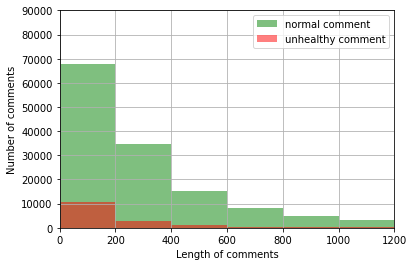

In [52]:
bins = [1,200,400,600,800,1000,1200]
H = train[train['unhealthiness'] == 0]['length']
U = train[train['unhealthiness'] > 0]['length']
plt.hist(H, alpha=0.5, bins=bins, color='green',label="normal comment")
plt.hist(U, alpha=0.5, bins=bins, color='red',  label="unhealthy comment")
plt.axis([0, 1200, 0, 90000])
plt.xlabel('Length of comments')
plt.ylabel('Number of comments') 
plt.legend()
plt.grid(True)
plt.show()

## Dominant words


In [53]:
wc_stopwords=set(STOPWORDS)
def generate_wordcloud_image(words):
    """Generate world could image"""
    image = WordCloud(
        max_words=5000, 
        min_font_size=5,
        width = 1000, 
        height = 500,
        stopwords=wc_stopwords, 
        background_color="black", 
        margin=5, 
        collocations=False,
        random_state=10
    ).generate(words)
    return image

### Healthy comment

In [54]:
words_healthy = " ".join(train[train['unhealthiness'] == 0]["comment_text"].values)


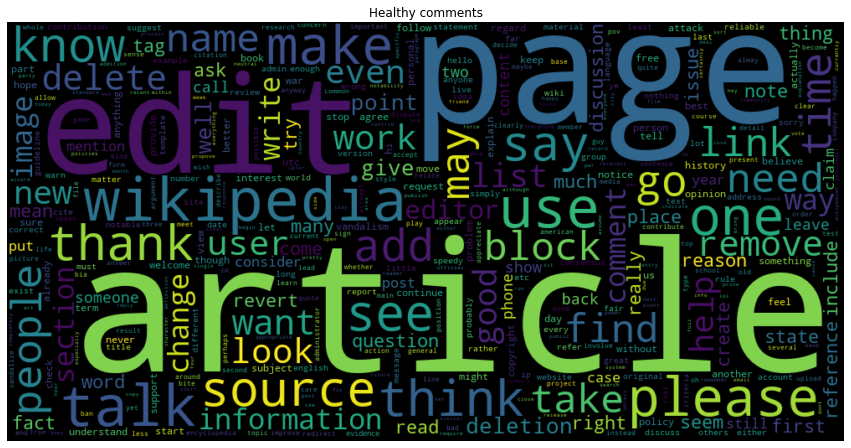

In [55]:
plt.figure(figsize=(15, 12))
plt.title("Healthy comments")
plt.axis("off")
plt.imshow(generate_wordcloud_image(words_healthy), interpolation = 'bilinear')

## Unhealthy  Comment

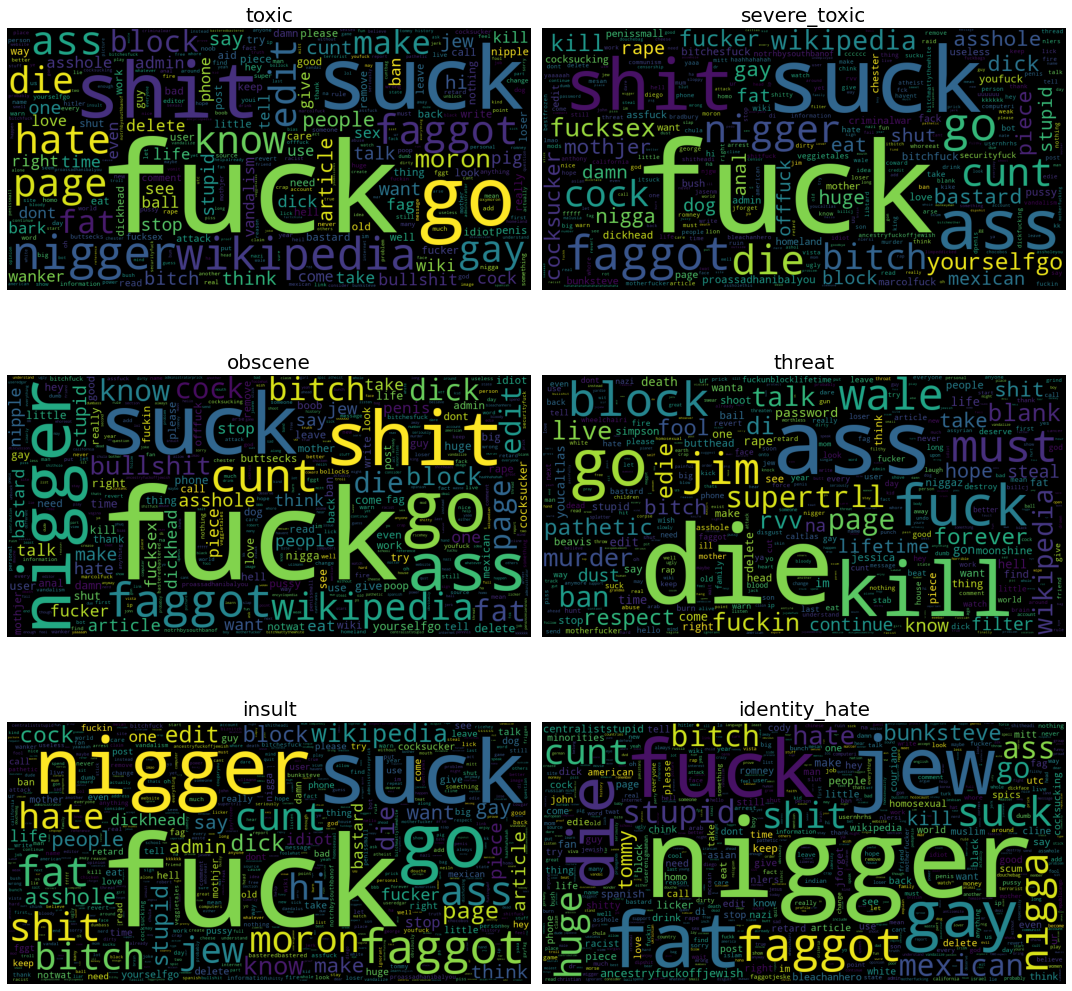

In [56]:
num_cols = 2
num_rows = len(CATEGORIES) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,15))
plt.axis('off')
images = []
for index, category in enumerate(CATEGORIES):
    image = generate_wordcloud_image(
        " ".join(train[train[category] == 1]["comment_text"].values)
    )
    images.append(image)

for index, category in enumerate(CATEGORIES):
    row = index // num_cols
    col = index % num_cols
    ax = axes[row][col]
    ax.imshow(images[index])
    ax.set_title(category, fontdict={'fontsize': 20, 'fontweight': 'medium'})
    for pos in ['top', 'bottom', 'right', 'left']:
        ax.spines[pos].set_visible(False)
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticklabels([])
        ax.set_yticks([])

fig.tight_layout()
plt.show()
del images

---
# Training the Models

Run BERT Fine Tuning on the data. The warning below is expected for the HuggingFace fine tuning.

```
Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```

* [Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification](https://github.com/huggingface/transformers/issues/5421#issuecomment-652582854)
> This is expected, and tells you that you won't have good performance with your BertForSequenceClassification model before you fine-tune it slightly_smiling_face.



## Fine Tuning Implementation

Utilize TensorFlow 2.x Keras for training the model. 

#### Keras Callbacks

Utilize [Keras Callbacks API](https://keras.io/api/callbacks/) to apply Eary Stopping, Reduce Learning Rate, and TensorBoard during the model training.



In [41]:
class SavePretrainedCallback(tf.keras.callbacks.Callback):
    """
    Hugging Face models have a save_pretrained() method that saves both 
    the weights and the necessary metadata to allow them to be loaded as 
    a pretrained model in future. This is a simple Keras callback that 
    saves the model with this method after each epoch.
    """
    def __init__(self, output_dir, **kwargs):
        super().__init__()
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        self.model.save_pretrained(self.output_dir)

class TensorBoardCallback(tf.keras.callbacks.TensorBoard):
    """TensorBoard visualization of the model training
    See https://keras.io/api/callbacks/tensorboard/
    """
    def __init__(self, output_directory):
        super().__init__(
            log_dir=output_directory,
            write_graph=True,
            write_images=True,
            histogram_freq=1,     # log histogram visualizations every 1 epoch
            embeddings_freq=1,    # log embedding visualizations every 1 epoch
            update_freq="epoch",      # every epoch
        )

class EaryStoppingCallback(tf.keras.callbacks.EarlyStopping):
    """Stop training when no progress on the metric to monitor
    See: 
    https://keras.io/api/callbacks/early_stopping/
    https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
    """
    def __init__(self, patience=3):
        assert patience > 0
        super().__init__(
            monitor='val_loss', 
            mode='min', 
            verbose=1, 
            patience=patience,
            restore_best_weights=True
        )

class ModelCheckpointCallback(tf.keras.callbacks.ModelCheckpoint):
    """Check point to save the model
    See https://keras.io/api/callbacks/model_checkpoint/

    NOTE: Did not work with HuggingFace with the error.
        NotImplementedError: Saving the model to HDF5 format requires the model 
        to be a Functional model or a Sequential model. 
        It does not work for subclassed models, because such models are defined 
        via the body of a Python method, which isn't safely serializable. 
    """
    def __init__(self, path_to_file):
        """
        Args:
            path_to_file: path to the model file to save at check points
        """
        super().__init__(
            filepath=path_to_file, 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True
        )

class ReduceLRCallback(tf.keras.callbacks.ReduceLROnPlateau):
    """Reduce learning rate when a metric has stopped improving.
    See https://keras.io/api/callbacks/reduce_lr_on_plateau/
    """
    def __init__(self, patience=3):
        assert patience > 0
        super().__init__(
            monitor="val_loss",
            factor=0.3,
            patience=patience,
        )

### Fine Tuning Runner

The Runner class implements the fine-tuning based on the [distilbert-base-uncased](https://huggingface.co/distilbert-base-uncased) pretrained model. Each classification category e.g. ```toxic``` will have a dedicated Runner class instance. The reason for using the ***Distilled*** BERT model is to run the training on the limited resources


In [42]:
class Runner:
    """Fine tuning implementation class
    See https://www.tensorflow.org/guide/keras/train_and_evaluate
    """
    # ================================================================================
    # Class
    # ================================================================================
    USE_HF_TRAINER = False
    # _model_name = 'distilbert-base-cased'
    _model_name = 'distilbert-base-uncased'
    _tokenizer = DistilBertTokenizerFast.from_pretrained(_model_name)

    # ================================================================================
    # Instance
    # ================================================================================
    # --------------------------------------------------------------------------------
    # Instance properties
    # --------------------------------------------------------------------------------
    @property
    def category(self):
        """Category of the text comment classification, e.g. toxic"""
        return self._category

    @property
    def batch_size(self):
        """Mini batch size during the training"""
        assert self._batch_size > 0
        return self._batch_size

    @property
    def X(self):
        """Training TensorFlow DataSet"""
        return self._X

    @property
    def V(self):
        """Validation TensorFlow DataSet"""
        return self._V

    @property
    def model_name(self):
        """HuggingFace pretrained model name"""
        return self._model_name

    @property
    def model(self):
        """TensorFlow/Keras Model instance"""
        return self._model

    @property
    def model_metric_names(self):
        """Model mtrics
        The attribute model.metrics_names gives labels for the scalar metrics
        to be returned from model.evaluate().
        """
        return self.model.metrics_names

    @property
    def history(self):
        """The history object returned from model.fit(). 
        The object holds a record of the loss and metric during training
        """
        assert self._history is not None
        return self._history

    @property
    def learning_rate(self):
        """Training learning rate"""
        return self._learning_rate

    @property
    def num_epochs(self):
        """Number of maximum epochs to run for the training"""
        return self._num_epochs

    @property
    def tokenizer(self):
        """BERT tokenizer. The Tokenzer must match the pretrained model"""
        return self._tokenizer

    @property
    def max_sequence_length(self):
        """Maximum token length for the BERT tokenizer can accept. Max 512
        """
        assert 128 <= self._max_sequence_length <= 512
        return self._max_sequence_length

    @property
    def trainer(self):
        """HuggingFace trainer instance
        HuggingFace offers an optimized Trainer because PyTorch does not have
        the training loop as Keras/Model has. It is available for TensorFlow
        as well, hence to be able to hold the instance in case using it.
        """
        return self._trainer

    @property
    def output_directory(self):
        """Parent directory to manage training artefacts"""
        return self._output_directory

    @property
    def model_directory(self):
        """Directory to save the trained models"""
        return self._model_directory

    @property
    def log_directory(self):
        """Directory to save logs, e.g. TensorBoard logs"""
        return self._log_directory

    # --------------------------------------------------------------------------------
    # Instance initialization
    # --------------------------------------------------------------------------------
    def __init__(
            self,
            category,
            training_data,
            training_label,
            validation_data,
            validation_label,
            max_sequence_length=256,
            batch_size=16,
            learning_rate=5e-5,
            num_epochs=3,
            output_directory="./output"
    ):
        self._category = category

        # --------------------------------------------------------------------------------
        # Keras Model
        # --------------------------------------------------------------------------------
        assert learning_rate > 0.0
        self._learning_rate = learning_rate
        self._model = None

        assert num_epochs > 0
        self._num_epochs = num_epochs

        assert batch_size > 0
        self._batch_size = batch_size
        
        # model.fit() result holder
        self._history = None  

        # --------------------------------------------------------------------------------
        # HuggingFace artefacts
        # --------------------------------------------------------------------------------
        assert 128 <= max_sequence_length <= 512
        self._max_sequence_length = max_sequence_length
        self._model = TFDistilBertForSequenceClassification.from_pretrained(self.model_name)
        self._trainer = None

        # --------------------------------------------------------------------------------
        # Output directories
        # --------------------------------------------------------------------------------
        # Parent directory
        self._output_directory = output_directory
        Path(self.output_directory).mkdir(parents=True, exist_ok=True)
        
        # Model directory
        self._model_directory = "{parent}/model_C{category}_B{size}_L{length}".format(
            parent=self.output_directory,
            category=self.category,
            size=self.batch_size,
            length=self.max_sequence_length
        )
        Path(self.model_directory).mkdir(parents=True, exist_ok=True)

        # Log directory
        self._log_directory = "{parent}/log_C{category}_B{size}_L{length}".format(
            parent=self.output_directory,
            category=self.category,
            size=self.batch_size,
            length=self.max_sequence_length
        )
        Path(self.log_directory).mkdir(parents=True, exist_ok=True)

        # --------------------------------------------------------------------------------
        # TensorFlow DataSet
        # --------------------------------------------------------------------------------
        assert np.all(np.isin(training_label, [0, 1]))
        assert np.all(np.isin(validation_label, [0, 1]))
        self._X = tf.data.Dataset.from_tensor_slices((
            dict(self.tokenizer(
                training_data,
                truncation=True,
                padding=True,
                max_length=self.max_sequence_length,
                return_tensors="tf"
            )),
            training_label
        ))
        self._V = tf.data.Dataset.from_tensor_slices((
            dict(self.tokenizer(
                validation_data,
                truncation=True,
                padding=True,
                max_length=self.max_sequence_length,
                return_tensors="tf"
            )),
            validation_label
        ))

    # --------------------------------------------------------------------------------
    # Instance methods
    # --------------------------------------------------------------------------------
    def _hf_train(self):
        """Train the model using HuggingFace Trainer"""
        self._training_args = TFTrainingArguments(
            output_dir='./results',             # output directory
            num_train_epochs=3,                 # total number of training epochs
            per_device_train_batch_size=self.batch_size,     # batch size per device during training
            per_device_eval_batch_size=self.batch_size,      # batch size for evaluation
            warmup_steps=500,                   # number of warmup steps for learning rate scheduler
            weight_decay=0.01,                  # strength of weight decay
            logging_dir='./logs',               # directory for storing logs
            logging_steps=10,
        )

        # with self._training_args.strategy.scope():
        #     self._model = TFDistilBertForSequenceClassification.from_pretrained(self.model_name)

        self._trainer = TFTrainer(
            model=self.model,
            args=self._training_args,   # training arguments
            train_dataset=self.X,       # training dataset
            eval_dataset=self.V         # evaluation dataset
        )
        self.trainer.train()

    def _keras_train(self):
        """Train the model using Keras
        """
        # --------------------------------------------------------------------------------
        # Build the model
        # --------------------------------------------------------------------------------
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.model.compile(
            optimizer=optimizer, 
            loss=self.model.compute_loss,
            # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            # ["accuracy", "AUC"] causes an error:
            # ValueError: Shapes (None, 1) and (None, 2) are incompatible
            metrics = ["accuracy"]  
        )
        self.model.summary()

        # --------------------------------------------------------------------------------
        # Train the model
        # --------------------------------------------------------------------------------
        self._history = self.model.fit(
            self.X.shuffle(1000).batch(self.batch_size).prefetch(1),
            epochs=self.num_epochs,
            batch_size=self.batch_size,
            validation_data=self.V.shuffle(1000).batch(self.batch_size).prefetch(1),
            callbacks=[
                EaryStoppingCallback(patience=3),
                # SavePretrainedCallback(output_dir=self.output_directory),
                ReduceLRCallback(patience=2),
                TensorBoardCallback(self.log_directory)
            ]
        )

    def train(self):
        """Run the model trainig"""
        if self.USE_HF_TRAINER:
            self._hf_train()
        else:
            self._keras_train()

    def evaluate(self, data, label):
        """Evaluate the model on the given data and label.
        https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
        The attribute model.metrics_names gives labels for the scalar metrics
        to be returned from model.evaluate().

        Args:
            data: data to run the prediction
            label: label for the data
        Returns: 
            scalar loss if the model has a single output and no metrics, OR 
            list of scalars (if the model has multiple outputs and/or metrics). 
        """
        assert np.all(np.isin(label, [0, 1]))
        test_dataset = tf.data.Dataset.from_tensor_slices((
            dict(self.tokenizer(
                data,
                truncation=True,
                padding=True,
                max_length=self.max_sequence_length,
                return_tensors="tf"
            )),
            label
        ))
        evaluation = self.model.evaluate(
            test_dataset.shuffle(1000).batch(self.batch_size).prefetch(1)
        )
        return evaluation

    def predict(self, data):
        """Calcuate the prediction for the data
        Args:
            data: text data to classify
        Returns: Probabilities for label value 0 and 1
        """
        tokens = dict(self.tokenizer(
            data,
            truncation=True,
            padding=True,
            max_length=self.max_sequence_length,
            return_tensors="tf"
        ))
        logits = self.model.predict(tokens)["logits"]
        # return logits
        return tf.nn.softmax(logits)

    def save(self, path_to_dir=None):
        """Save the model from the HuggingFace. 
        - config.json 
        - tf_model.h5  

        Args:
            path_to_dir: directory path to save the HuggingFace model artefacts
        """

        if path_to_dir is None or len(path_to_dir) == 0:
            path_to_dir = self.model_directory
        Path(path_to_dir).mkdir(parents=True, exist_ok=True)
        if self.USE_HF_TRAINER:
            self.trainer.save_model(path_to_dir)  
        else:
            self.model.save_pretrained(path_to_dir)

    def load(self, path_to_dir):
        """Load the model as the HuggingFace format.
        Args:
            path_to_dir: Directory path from where to load config.json and .h5.
        """
        if os.path.isdir(path_to_dir) and os.access(path_to_dir, os.R_OK):
            self._model = TFDistilBertForSequenceClassification.from_pretrained(path_to_dir)
        else:
            raise RuntimeError(f"{path_to_dir} does not exit")

## Run Training

In [46]:
# HuggingFace
MAX_SEQUENTH_LENGTH = 256   # Max token length to accept

# Model training
NUM_EPOCHS = 5
BATCH_SIZE = 32

# Result output directory
TIMESTAMP = datetime.datetime.now().strftime("%Y%b%d%H%M").upper()
RESULT_DIRECTORY = f"/content/drive/MyDrive/data/toxicity_classification_{TIMESTAMP}"


In [47]:
def run(category):
    """Wrapper to create the Runnler instances for the respective category"""
    print("\n--------------------------------------------------------------------------------")
    print(f"Model training on [{category}]")
    print("--------------------------------------------------------------------------------")

    data = train['comment_text'].tolist()
    label = train[category].tolist()

    train_data, validation_data, train_label, validation_label = train_test_split(
        data,
        label,
        test_size=.2,
        shuffle=True
    )
    runner = Runner(
        category=category,
        training_data=train_data,
        training_label=train_label,
        validation_data=validation_data,
        validation_label=validation_label,
        batch_size=BATCH_SIZE,
        max_sequence_length=MAX_SEQUENTH_LENGTH,
        num_epochs=NUM_EPOCHS,
        output_directory=RESULT_DIRECTORY
    )
    
    runner.train()
    runner.save()

    print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"Model evaluation on [{category}]")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    test_data = test['comment_text'].tolist()
    test_label = test[category].tolist()
    evaluation = runner.evaluate(test_data, test_label)
    print(f"Evaluation: {runner.model_metric_names}:{evaluation}")

    return runner, evaluation

In [48]:
runners = {}      # To save the Runner instance for each category.
evaluations = {}  # Evaluation results for each category

for category in CATEGORIES:
    runners[category], evaluations[category] = run(category)


--------------------------------------------------------------------------------
Model training on [toxic]
--------------------------------------------------------------------------------
Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  1538      
_________________________________________________________________
dropout_39 (Dropout)         multiple                  0         
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
3990/3990

KeyboardInterrupt: ignored

---
# TensorBoard

Examine the model trainig history in the TensorBoard.

In [ ]:
category = 'toxic'
%reload_ext tensorboard
%tensorboard --logdir {RESULT_DIRECTORY}/log_C{category}_B{BATCH_SIZE}_L{MAX_SEQUENTH_LENGTH}

In [ ]:
category = 'threat'
%reload_ext tensorboard
%tensorboard --logdir {RESULT_DIRECTORY}/log_C{category}_B{BATCH_SIZE}_L{MAX_SEQUENTH_LENGTH}

---
# Test

### Instantiate predictors from the save models

In [ ]:
test_data = test['comment_text'].tolist()
test_label = test[category].tolist()

dummy_data = test_data[:5]
dummy_label = test_label[:5]
id=""
predictors = {}

for category in CATEGORIES:
    predictor = Runner(
        category=category,
        training_data=dummy_data,
        training_label=dummy_label,
        validation_data=dummy_data,
        validation_label=dummy_label,
        batch_size=BATCH_SIZE,
        max_sequence_length=MAX_SEQUENTH_LENGTH,
    )
    path_to_dir = "{parent}/model_C{category}_B{size}_L{length}".format(
        parent=RESULT_DIRECTORY,
        category=category,
        size=BATCH_SIZE,
        length=MAX_SEQUENTH_LENGTH
    )
    predictor.load(path_to_dir)
    predictors[category] = predictor

### Predictions

In [ ]:
row = {}
index = np.random.randint(0, len(test_data))
data = test_data[index]
row['data'] = data
for category in CATEGORIES:
    row[category] = np.argmax(predictors[category].predict(data).numpy().tolist()[0])

pd.DataFrame([row])

### True Ratings

True results.

In [ ]:
raw_test.iloc[[index]]